In [1]:
import tensorflow as tf

In [2]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
  print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [4]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift=1)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(),end=' ')
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [5]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift=1,drop_remainder=True)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(),end=' ')
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [7]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [8]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
dataset = dataset.map(lambda window : (window[:-1],window[-1:]))
for x,y in dataset:
  print(x.numpy(),y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [9]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
dataset = dataset.map(lambda window : (window[:-1],window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
  print(x.numpy(),y.numpy())

[1 2 3 4] [5]
[5 6 7 8] [9]
[0 1 2 3] [4]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]


In [10]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda window:window.batch(5))
dataset = dataset.map(lambda window : (window[:-1],window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print(x.numpy(),y.numpy())

[[1 2 3 4]
 [5 6 7 8]] [[5]
 [9]]
[[3 4 5 6]
 [4 5 6 7]] [[7]
 [8]]
[[2 3 4 5]
 [0 1 2 3]] [[6]
 [4]]


In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [31]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [32]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_test = time[split_time:]
x_test = series[split_time:]

In [33]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [34]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.04533526],
       [-0.03797026],
       [ 0.11972911],
       [-0.06052407],
       [ 0.05429479],
       [-0.07602375],
       [ 0.05735184],
       [ 0.00864661],
       [-0.02795929],
       [ 0.07120433],
       [-0.09468099],
       [-0.01548367],
       [-0.01318612],
       [ 0.08701703],
       [ 0.00442792],
       [ 0.0447865 ],
       [ 0.06901632],
       [ 0.13838749],
       [ 0.25048214],
       [ 0.45820886]], dtype=float32), array([0.0178666], dtype=float32)]


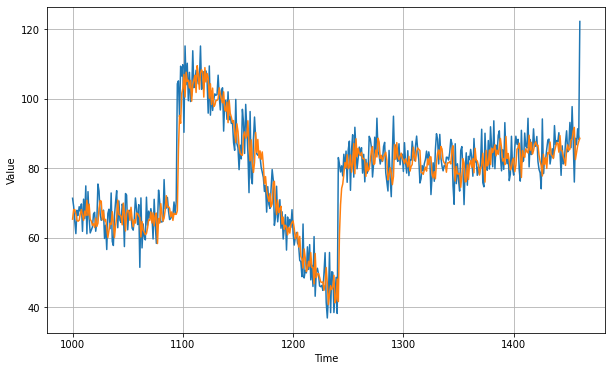

In [35]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Dense(10,input_shape=[window_size],activation='relu'),
  tf.keras.layers.Dense(10,activation='relu'),
  tf.keras.layers.Dense(1)                            
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8 * 10**(epoch/20)
)
model2.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(lr=8e-6,momentum=0.9),metrics=['acc','mae'])
history = model2.fit(dataset,epochs=150,verbose=1)

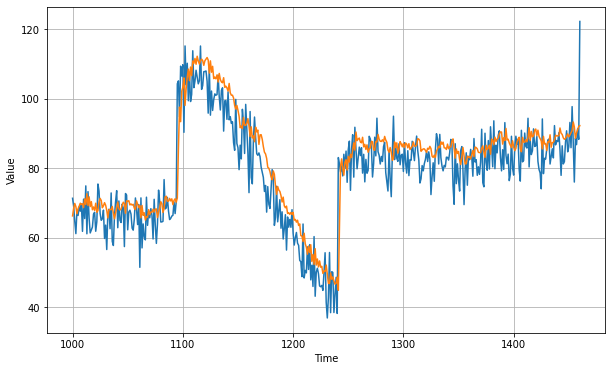

In [51]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model2.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

(1e-08, 0.001, 0.0, 300.0)

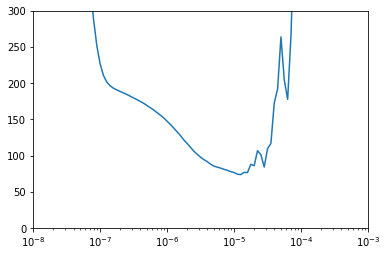

In [48]:
lrs = 1e-8*(10**(np.arange(150)/20))
plt.semilogx(lrs,history.history['loss'])
plt.axis([1e-8,1e-3,0,300])

In [52]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.773199

In [ ]:
train_set = windowed_dataset(x_train,window_size,batch_size=128,shuffle_buffer=shuffle_buffer_size)

model3 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis=-1),input_shape=[None]),
    tf.keras.layers.SimpleRNN(40,return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x*100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8*10**(epoch/20))

model3.compile(loss = tf.keras.losses.Huber(),
               optimizer = tf.keras.optimizers.SGD(lr =5e-5,momentum=0.9),
               metrics=['mae'])
history = model3.fit(train_set,epochs=100)

(1e-08, 0.001, 0.0, 300.0)

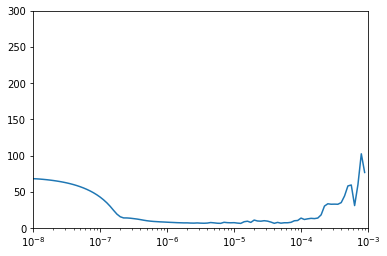

In [67]:
lrs = 1e-8*(10**(np.arange(100)/20))
plt.semilogx(lrs,history.history['loss'])
plt.axis([1e-8,1e-3,0,300])

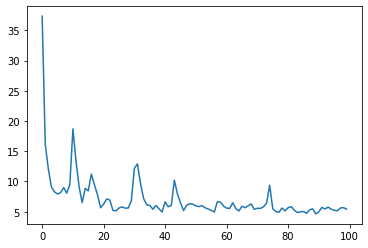

In [69]:
loss = history.history['loss']
plt.plot(loss)

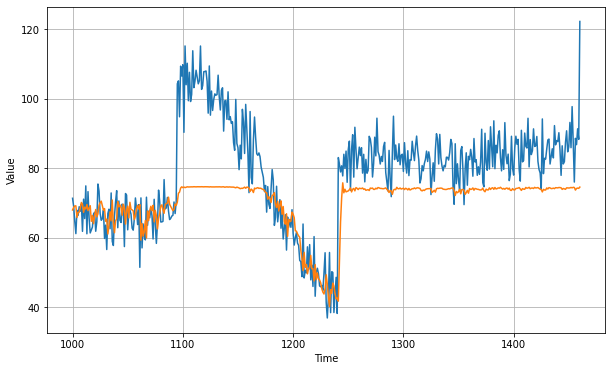

In [70]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model3.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)                         
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

model4.compile(loss='mse',optimizer = tf.keras.optimizers.SGD(lr=5e-6,momentum=0.9),metrics=['mae'])
history = model4.fit(train_set,epochs=100,verbose=1,)

(1e-08, 0.001, 0.0, 300.0)

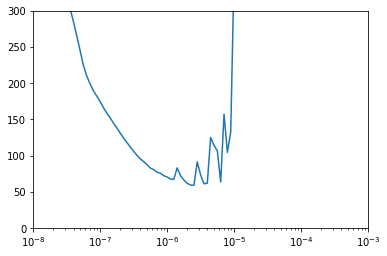

In [77]:
lrs = 1e-8*(10**(np.arange(100)/20))
plt.semilogx(lrs,history.history['loss'])
plt.axis([1e-8,1e-3,0,300])

In [95]:
rnn_forecast = model_forecast(model4, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

IndexError: ignored

In [ ]:
model5 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200.0)   
])

model5.compile(loss = tf.keras.losses.Huber(),
               optimizer= tf.keras.optimizers.SGD(lr=1e-5,momentum=0.9),
               metrics=['mae'])
history = model5.fit(train_set2,epochs=100)

In [88]:
def windowed_dataset2(series,window_size,batch_size,shuffle_buffer):
  series = tf.expand_dims(series,axis=-1)

  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1,shift=1,drop_remainder=True)
  ds = ds.flat_map(lambda w : w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1]))

  return ds.batch(batch_size).prefetch(1)

In [89]:
train_set2 = windowed_dataset2(series,window_size,batch_size=128,shuffle_buffer=shuffle_buffer_size)

In [93]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model5, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

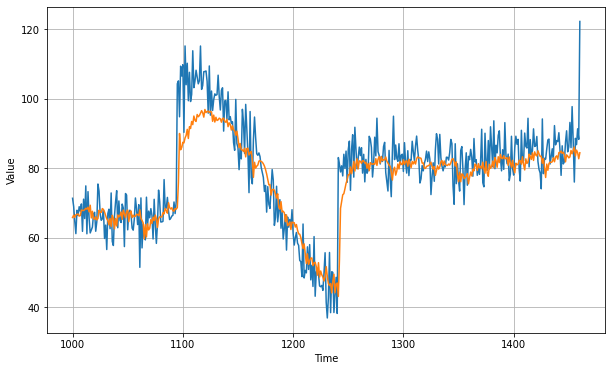

In [94]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [133]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-01-19 07:18:04--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 108.177.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-01-19 07:18:04 (76.5 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [134]:
import csv
time_step = []
sunspots = []
with open('/tmp/sunspots.csv') as file:
  reader = csv.reader(file,delimiter=',')
  next(reader)
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

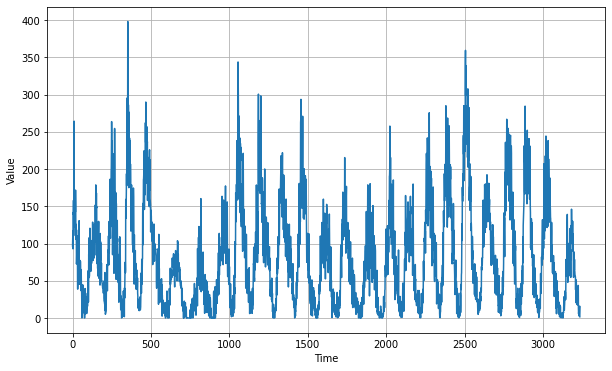

In [135]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [136]:
len(series)


3235

In [137]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
print(x_train.shape)
time_test = time[split_time:]
x_test = series[split_time:]


(2000,)


In [138]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [139]:
def rnn_forecast3(model,series,window_size,batch_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder=True)
  ds = ds.flat_map(lambda w:w.batch_size(window_size))
  ds = ds.batch_size(batch_size).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [140]:
window_size = 64
batch_size = 256
train_set = windowed_dataset3(x_train,window_size,batch_size,1000)

<TensorSliceDataset shapes: (1,), types: tf.float64>


In [141]:
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(2000,)


In [142]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = tf.keras.optimizers.SGD(lr = 1e-8,momentum = 0.9),
              metrics = ['mae'])

history = model.fit(train_set, epochs=100, verbose=1, callbacks=[lr_schedule])


Epoch 1/100
8/8 [==============================] - 6s 324ms/step - loss: 57.1865 - mae: 57.6848
Epoch 2/100
8/8 [==============================] - 3s 331ms/step - loss: 56.8725 - mae: 57.3708
Epoch 3/100
8/8 [==============================] - 3s 330ms/step - loss: 56.2443 - mae: 56.7425
Epoch 4/100
8/8 [==============================] - 3s 334ms/step - loss: 56.7712 - mae: 57.2695
Epoch 5/100
8/8 [==============================] - 3s 335ms/step - loss: 57.6998 - mae: 58.1980
Epoch 6/100
8/8 [==============================] - 3s 333ms/step - loss: 56.0889 - mae: 56.5870
Epoch 7/100
8/8 [==============================] - 3s 335ms/step - loss: 57.3067 - mae: 57.8050
Epoch 8/100
8/8 [==============================] - 3s 339ms/step - loss: 56.3398 - mae: 56.8379
Epoch 9/100


KeyboardInterrupt: ignored

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [144]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
20/20 [==============================] - 6s 132ms/step - loss: 51.1647 - mae: 51.6621
Epoch 2/100
20/20 [==============================] - 3s 126ms/step - loss: 29.8592 - mae: 30.3534
Epoch 3/100
20/20 [==============================] - 3s 130ms/step - loss: 25.1830 - mae: 25.6770
Epoch 4/100
20/20 [==============================] - 3s 128ms/step - loss: 22.2916 - mae: 22.7845
Epoch 5/100
20/20 [==============================] - 3s 126ms/step - loss: 20.9868 - mae: 21.4787
Epoch 6/100
20/20 [==============================] - 3s 126ms/step - loss: 20.6168 - mae: 21.1094
Epoch 7/100
20/20 [==============================] - 3s 128ms/step - loss: 19.6398 - mae: 20.1320
Epoch 8/100
20/20 [==============================] - 3s 129ms/step - loss: 19.0357 - mae: 19.5272
Epoch 9/100
20/20 [==============================] - 3s 127ms/step - loss: 18.5608 - mae: 19.0521
Epoch 10/100
20/20 [==============================] - 3s 127ms/step - loss: 20.7440 - mae: 21.2367
Epoch 11/100
20/20 

In [145]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

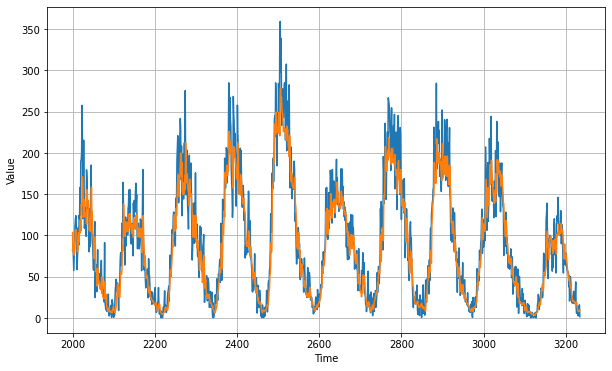

In [147]:
plt.figure(figsize=(10, 6))
plot_series(time_test, x_test)
plot_series(time_test, rnn_forecast)

<Figure size 432x288 with 0 Axes>

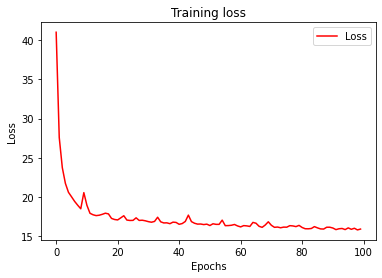

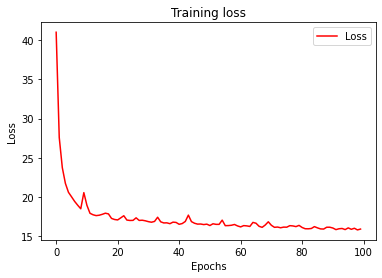

<Figure size 432x288 with 0 Axes>

In [150]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[:100]
zoomed_epochs = range(0,100)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()